In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nltk
import nltk.sentiment
import re

import warnings
warnings.filterwarnings('ignore')

from prepare import prep_readme_data
import model
import nltk.sentiment

from sklearn.preprocessing import MinMaxScaler

from acquire import prepare_data

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [2]:
plt.rc('figure', figsize=(13, 7))
plt.rc('font', size=14)
plt.style.use('seaborn-darkgrid')

In [3]:
movie_title = pd.read_csv("IMDb movies.csv")

In [4]:
# What is are biggest markets in terms of movie production? 

movie_title.groupby("country").title.count().sort_values(ascending=False).nlargest(5)

country
USA       27490
India      5540
UK         3869
France     2975
Japan      2850
Name: title, dtype: int64

In [5]:
# What year did most movies get published?

movie_title.groupby("date_published").title.count().nlargest(10)

date_published
2010    111
1999    105
2008    101
1997     92
1985     90
1996     89
2009     89
1989     85
2011     85
1987     84
Name: title, dtype: int64

In [6]:
# What data range do we have? 

movie_title.date_published.min(), movie_title.date_published.max()

('1906-12-26', '2020-05-22')

In [7]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt']

def clean(text: str) -> list:
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (text.encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split() # tokenization
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

For the purposes of this project, we will only look to use movies from the US. If the opportunity to scale up the project is possible, then we will add additional countries.

In [8]:
df = movie_title[(movie_title.country == "USA")]

In [9]:
# we see that we have a couple of missing values.
df.isnull().sum()

imdb_title_id                0
title                        0
original_title               0
year                         0
date_published               0
genre                        0
duration                     0
country                      0
language                   307
director                    28
writer                     191
production_company        1139
actors                      22
description                 76
avg_vote                     0
votes                        0
budget                   17213
usa_gross_income         19940
worlwide_gross_income    19710
metascore                21145
reviews_from_users         279
reviews_from_critics      1728
dtype: int64

**Steps for Removing Null Values**:

1. The movie description will be a large part indicator or similarity, and as such, I want movies that have a description. I will drop any null values in this column
1. I will explore that language column, as I suspect at this moment that these shoud be all inglish
1. Similarly to the description, the director would play a big influence and as such I am thinking of dropping all null values from this column
1. While the meta score value would be really useful - there are too many missing values, and as such I will drop this column. Same for the `reviews_from_critics`
1. Might be able to impude a value for the missing `reviews_from_users`
1. I might be able to find the missing writers from the other IMBD file


In [10]:
# Given that hte majority of the movies are exclusively English, and we know that we are only looking at movies
# made in the US, I can speculate that it is very likely these movies were at least partially made in english
# As such, I will impode the missing values

df.language.value_counts()

English                                             23976
English, Spanish                                      695
English, French                                       440
English, German                                       198
English, Italian                                      195
                                                    ...  
English, Icelandic, Italian                             1
Greek, English                                          1
English, Spanish Sign Language                          1
English, French, Turkish, German, Greek, Italian        1
English, Greek, Italian                                 1
Name: language, Length: 629, dtype: int64

In [11]:
df.language = df.language.fillna("English")

In [12]:
# remove nulls from director and description

df = df[df.description.notnull()]

In [13]:
df = df[df.director.notnull()]

In [14]:
df = df[df.writer.notnull()]

In [15]:
# What is the avg budget for all movies so that we can use it to impude values?

df.budget = df.budget.fillna("$ 0")

In [16]:
df = df[~df.budget.str.contains("ESP")]

df = df[~df.budget.str.contains("GBP")]

df = df[~df.budget.str.contains("CAD")]

df = df[~df.budget.str.contains("PYG")]

df = df[~df.budget.str.contains("AUD")]

df = df[~df.budget.str.contains("EUR")]

df = df[~df.budget.str.contains("RUR")]

In [17]:
avg_budget = df.budget.str.replace("$", '').astype(int).mean()

In [18]:
df.budget = df.budget.str.replace("$", '').astype(int)

In [19]:
df.budget = df.budget.replace(0, avg_budget)

In [20]:
# We will do something similar for US gross income

median_income = df[(df.usa_gross_income.notnull()) & (df.usa_gross_income.str.contains("$", regex=False))].usa_gross_income.str.replace("$", '').astype(int).median()

In [21]:
df.usa_gross_income = df.usa_gross_income.fillna("$ 0")

In [22]:
df.usa_gross_income = (
    df[df.usa_gross_income.str.contains("$", regex=False)]
    .usa_gross_income.str.replace("$", '')
    .astype(int)
    .replace(0, median_income)
)

In [23]:
# Remove columns with too many null values

df = df.drop(columns=["worlwide_gross_income", "metascore", "reviews_from_users", "reviews_from_critics"])

In [24]:
# Drop any remaining null values

df = df.dropna()

In [25]:
# Now we have no null values, and still have over 26000 movie titles

df.isnull().sum(), df.shape

(imdb_title_id         0
 title                 0
 original_title        0
 year                  0
 date_published        0
 genre                 0
 duration              0
 country               0
 language              0
 director              0
 writer                0
 production_company    0
 actors                0
 description           0
 avg_vote              0
 votes                 0
 budget                0
 usa_gross_income      0
 dtype: int64, (26102, 18))

## NLP Exploration

In [26]:
df_prep = prep_readme_data(df, "description")

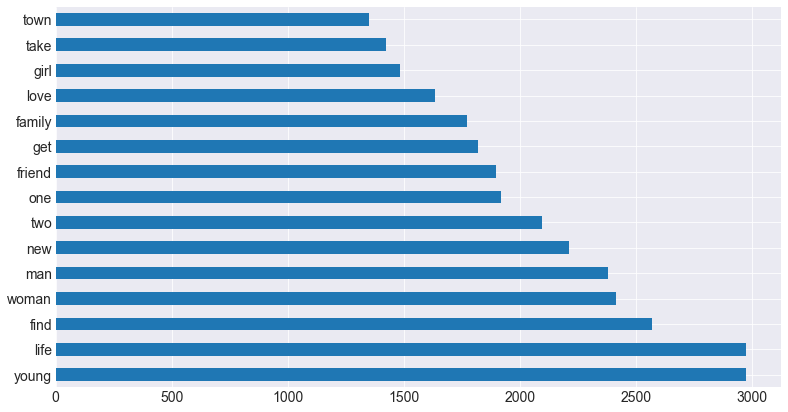

In [27]:
# What are the most common words in movie descriptions?

all_words = clean(' '.join(df.description))

pd.Series(all_words).value_counts().head(15).plot.barh()


### Common words by genre?

In [28]:
# What are the top most common genres?

df.genre.value_counts().head(5)

Drama             2294
Comedy            1810
Comedy, Drama      953
Horror             947
Drama, Romance     886
Name: genre, dtype: int64

In [29]:
drama = clean(' '.join(df[df.genre == "Drama"].description))
comedy = clean(' '.join(df[df.genre == "Comedy"].description))
comedy_drama = clean(' '.join(df[df.genre == "Comedy, Drama"].description))
horror = clean(' '.join(df[df.genre == "Horror"].description))
drame_romance = clean(' '.join(df[df.genre == "Drama, Romance"].description))

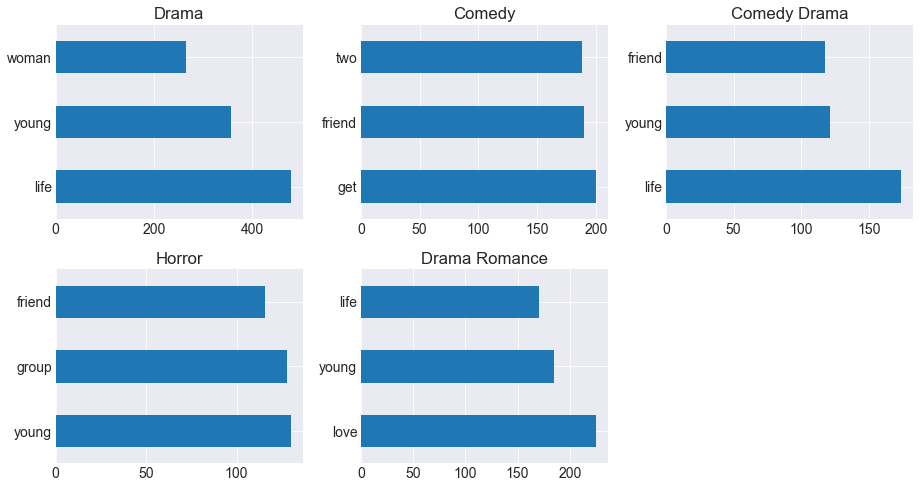

In [30]:
plt.subplot(2,3,1)
pd.Series(drama).value_counts().head(3).plot.barh()
plt.title("Drama")
plt.subplot(2,3,2)
pd.Series(comedy).value_counts().head(3).plot.barh()
plt.title("Comedy")
plt.subplot(2,3,3)
pd.Series(comedy_drama).value_counts().head(3).plot.barh()
plt.title("Comedy Drama")
plt.subplot(2,3,4)
pd.Series(horror).value_counts().head(3).plot.barh()
plt.title("Horror")
plt.subplot(2,3,5)
pd.Series(drame_romance).value_counts().head(3).plot.barh()
plt.title("Drama Romance")

plt.tight_layout()
plt.show()


### Common words throughout time?

In [31]:
def most_frequent_bigram(s: pd.Series) -> str:
    # your code might be more or less complicated here, depending on how much
    # text prep you've already done or more you want to do in this function
    words = clean(' '.join(s))
    most_common_bigram = pd.Series(nltk.bigrams(words)).value_counts().head(1).index
    return most_common_bigram

In [32]:
df.date_published = pd.to_datetime(df.date_published)

In [33]:
most_common_bigrams = df.set_index('date_published').resample('Y').description.agg([most_frequent_bigram, "count"])

In [34]:
most_common_bigrams["most_frequent_bigram"][0]

('general', 'marc')

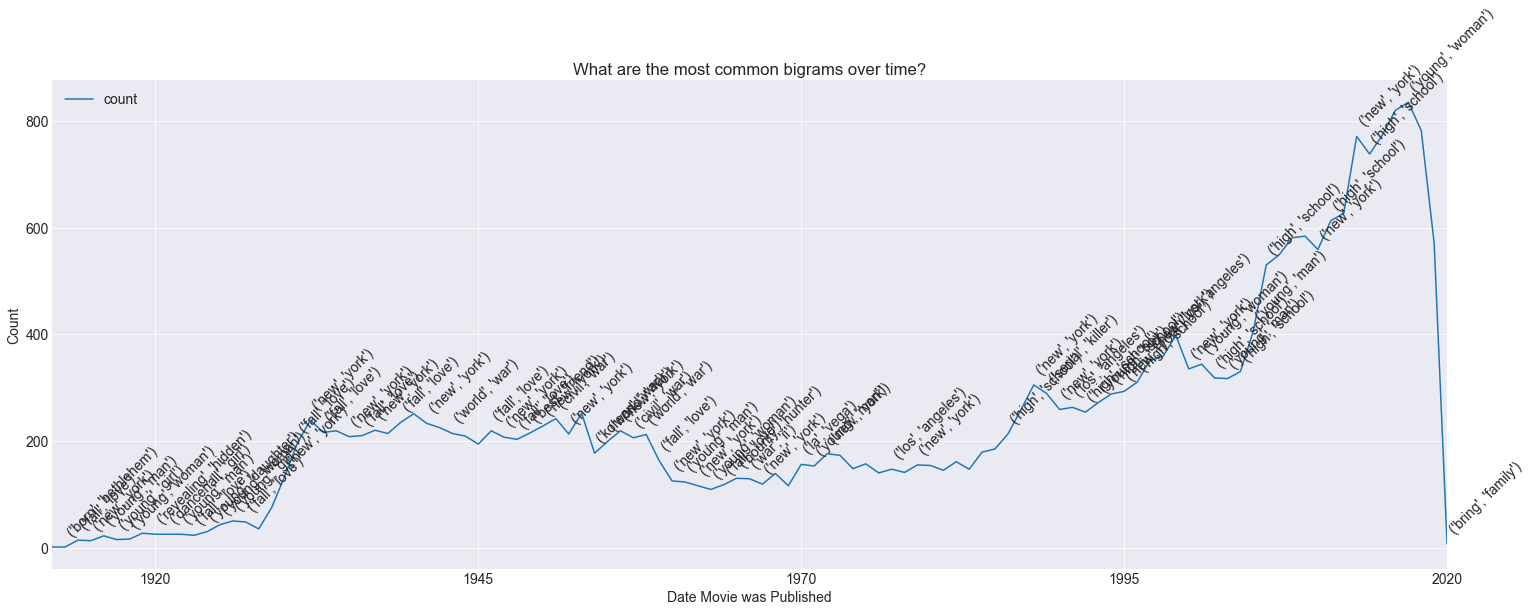

In [35]:
fig, ax = plt.subplots(figsize=(25, 9))
most_common_bigrams.plot(ax=ax)
plt.title("What are the most common bigrams over time?")
plt.ylabel("Count")
plt.xlabel("Date Movie was Published")
for i in range(1, most_common_bigrams.shape[0]):
    if most_common_bigrams["most_frequent_bigram"][i] != most_common_bigrams["most_frequent_bigram"][i-1]:
        ax.text(f"{most_common_bigrams.index[i]}", most_common_bigrams["count"][i] + 20,  f"{most_common_bigrams.most_frequent_bigram[i]}", rotation = 45)

### Common bigrams in high voted movies vs low?

In [36]:
most_common_bigrams = df.groupby("avg_vote").description.agg([most_frequent_bigram, "count"])

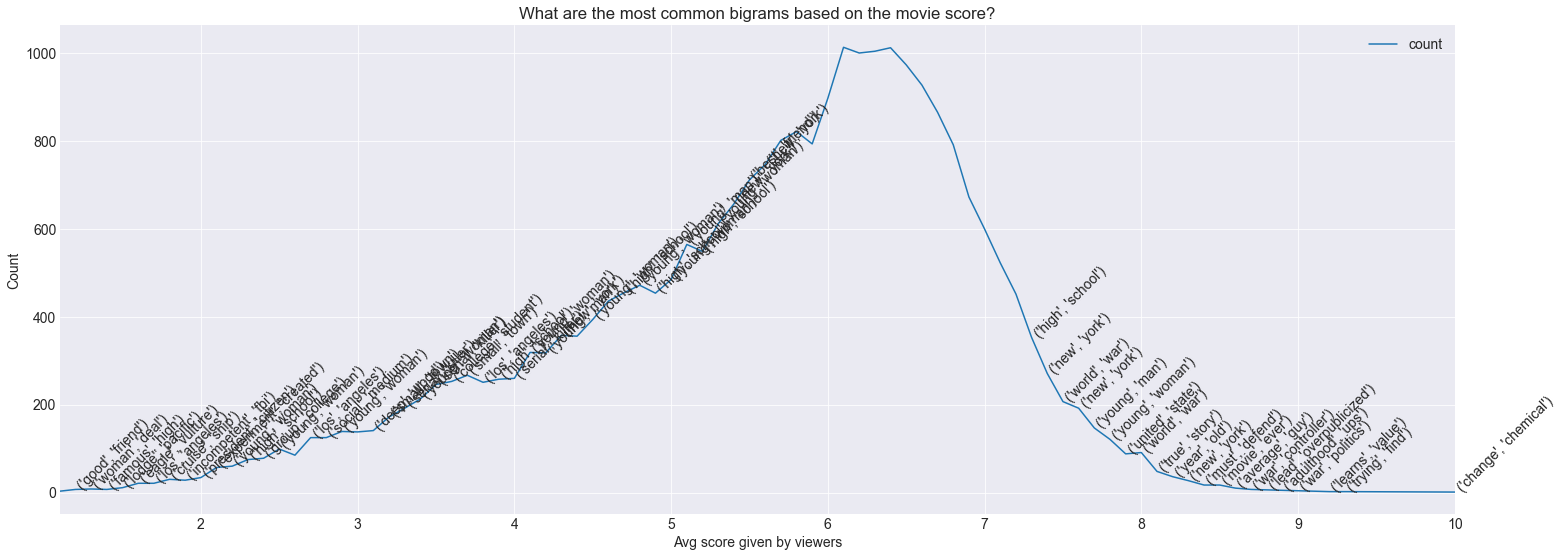

In [37]:
fig, ax = plt.subplots(figsize=(25, 9))
most_common_bigrams.plot(ax=ax)
plt.title("What are the most common bigrams based on the movie score?")
plt.ylabel("Count")
plt.xlabel("Avg score given by viewers")
for i in range(1, most_common_bigrams.shape[0]):
    if most_common_bigrams["most_frequent_bigram"].iloc[i] != most_common_bigrams["most_frequent_bigram"].iloc[i-1]:
        ax.text(most_common_bigrams.index[i], most_common_bigrams["count"].iloc[i],  f"{most_common_bigrams.most_frequent_bigram.iloc[i]}", rotation = 45)

### Common words in high grossing movies vs low?

In [38]:
df["usa_gross_bin"] = pd.cut(df.usa_gross_income, 10, labels=[1,2,3,4,5,6,7,8,9, 10])

In [39]:
most_common_bigrams = df.groupby("usa_gross_bin").description.agg([most_frequent_bigram, "count"])

In [40]:
df[df["usa_gross_bin"] == 10]

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,description,avg_vote,votes,budget,usa_gross_income,basic_clean,clean_tokes,lemmatized,clean_lemmatized,usa_gross_bin
65123,tt2488496,Star Wars: Episode VII - The Force Awakens,Star Wars: Episode VII - The Force Awakens,2015,2015-12-17,"Action, Adventure, Sci-Fi",138,USA,English,J.J. Abrams,...,"Three decades after the Empire's defeat, a new...",7.9,800030,245000000.0,936662225.0,three decades after the empires defeat a new t...,"[three, decades, after, the, empires, defeat, ...",three decade after the empire defeat a new thr...,three decade empire defeat new threat arises m...,10
71243,tt4154796,Avengers: Endgame,Avengers: Endgame,2019,2019-04-25,"Action, Adventure, Drama",181,USA,"English, Japanese, Xhosa, German","Anthony Russo, Joe Russo",...,After the devastating events of,8.5,602792,356000000.0,858373000.0,after the devastating events of,"[after, the, devastating, events, of]",after the devastating event of,devastating event,10


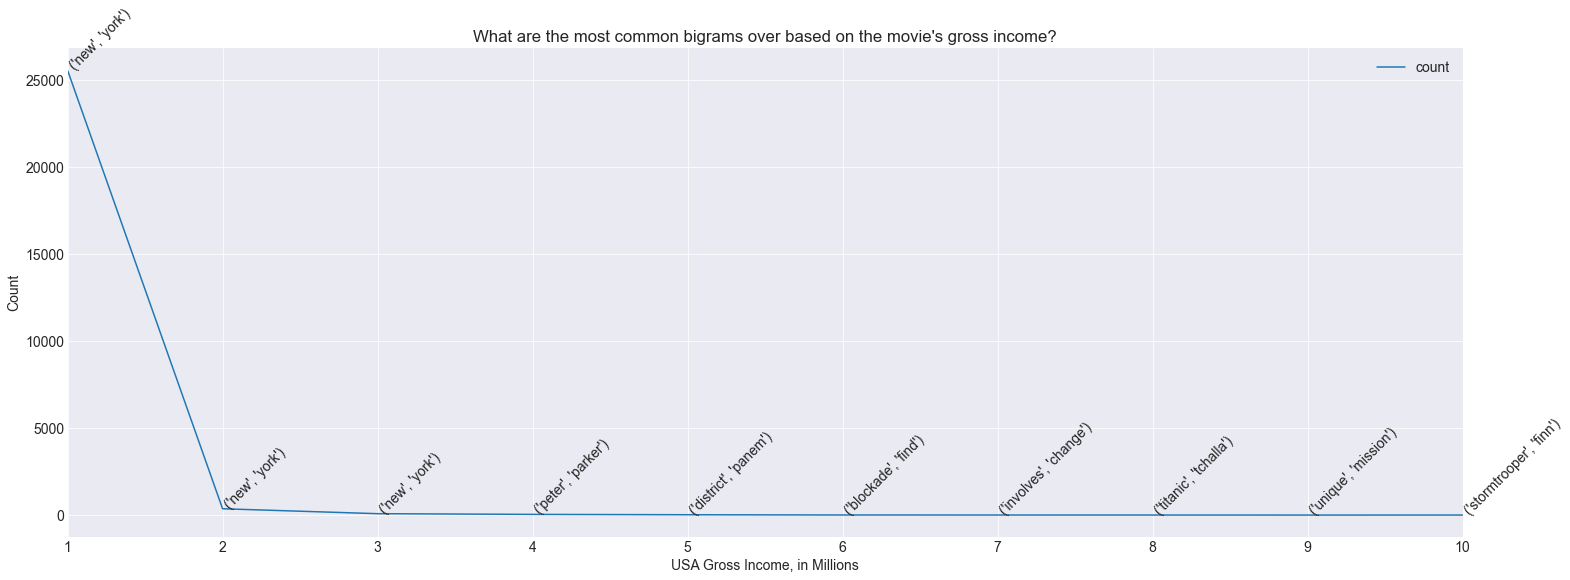

In [41]:
fig, ax = plt.subplots(figsize=(25, 9))
most_common_bigrams.plot(ax=ax)
plt.title("What are the most common bigrams over based on the movie's gross income?")
plt.ylabel("Count")
plt.xlabel("USA Gross Income, in Millions")
for i in most_common_bigrams.index:
    ax.text(i-1, most_common_bigrams["count"][i],  f"{most_common_bigrams.most_frequent_bigram[i]}", rotation = 45)

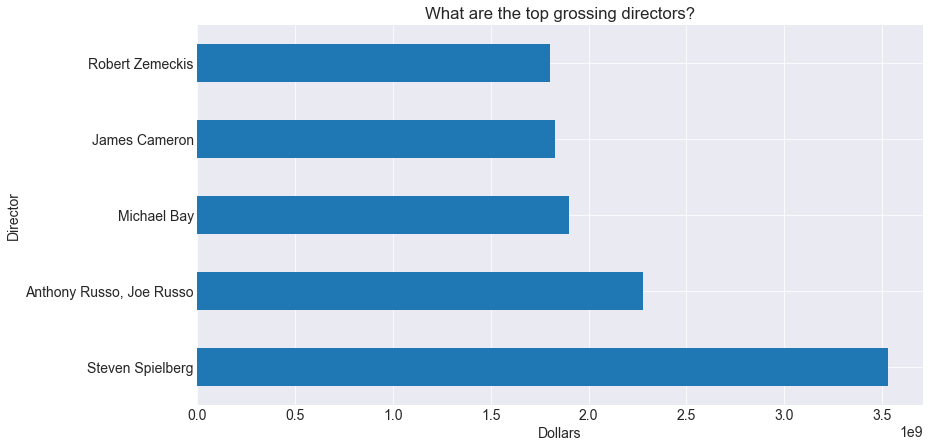

In [42]:
# what are highest grossing directors of all times?


df.groupby("director").usa_gross_income.sum().sort_values(ascending=False).head(5).plot.barh()
plt.title("What are the top grossing directors?")
plt.xlabel("Dollars")
plt.ylabel("Director")
plt.show()

Text(0, 0.5, 'Genre')

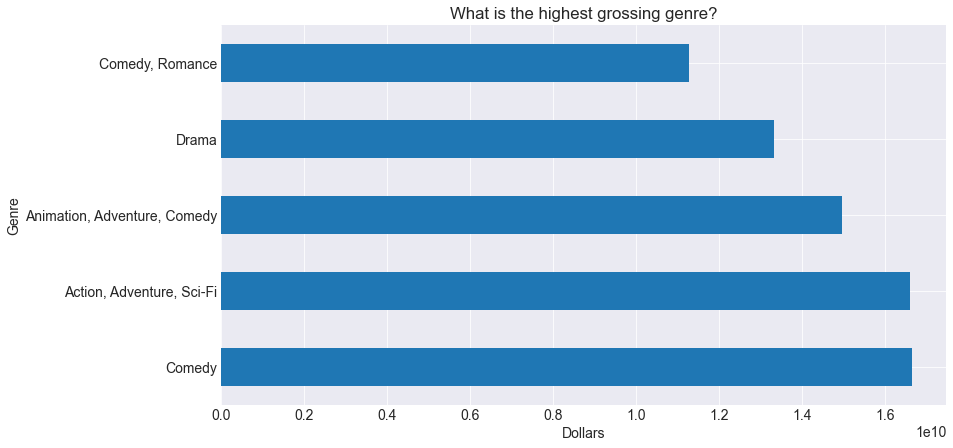

In [43]:
# what are the top genres by genre?

df.groupby("genre").usa_gross_income.sum().sort_values(ascending=False).head(5).plot.barh()
plt.title("What is the highest grossing genre?")
plt.xlabel("Dollars")
plt.ylabel("Genre")

In [44]:
df[df.genre == "Animation, Drama, Sci-Fi"]

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,description,avg_vote,votes,budget,usa_gross_income,basic_clean,clean_tokes,lemmatized,clean_lemmatized,usa_gross_bin
53180,tt1196334,After Last Season,After Last Season,2009,2009-06-05,"Animation, Drama, Sci-Fi",93,USA,English,Mark Region,...,Two neurology students create a telepathy expe...,1.6,7767,30000.0,5548375.0,two neurology students create a telepathy expe...,"[two, neurology, students, create, a, telepath...",two neurology student create a telepathy exper...,two neurology student create telepathy experim...,1


Text(0, 0.5, 'Director')

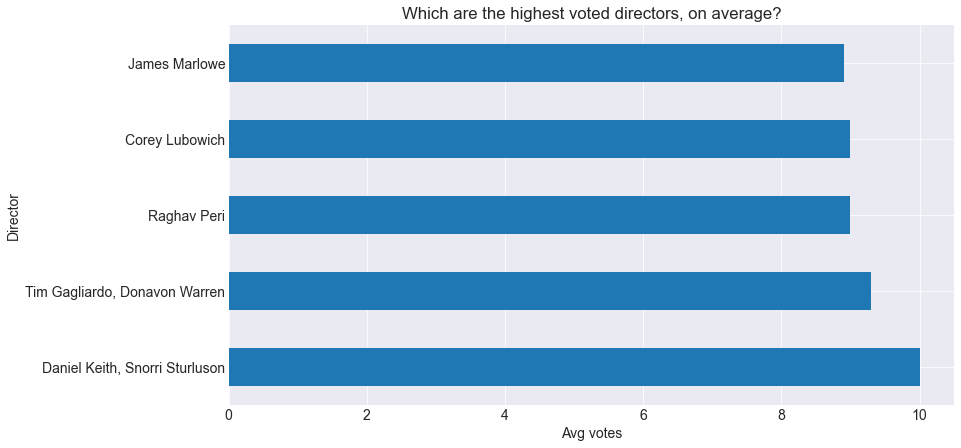

In [45]:
# what are the highest voted directors?

df.groupby("director").avg_vote.mean().sort_values(ascending=False).head(5).plot.barh()
plt.title("Which are the highest voted directors, on average?")
plt.xlabel("Avg votes")
plt.ylabel("Director")

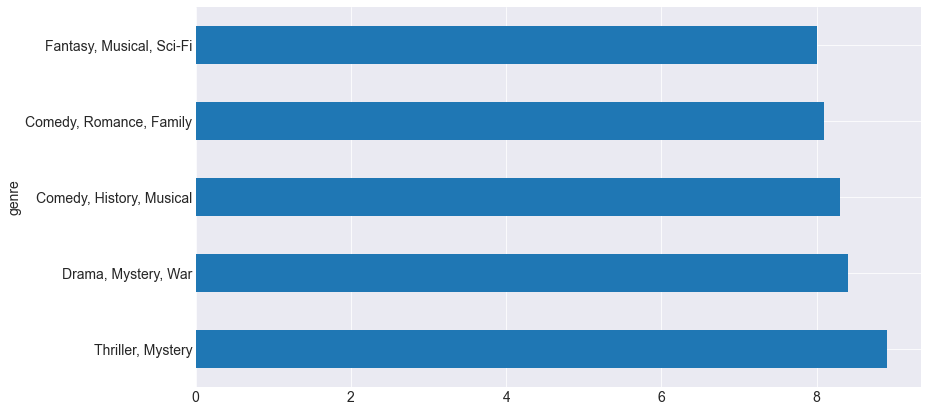

In [46]:
# What are the highest voted genres?

df.groupby("genre").avg_vote.mean().sort_values(ascending=False).head(5).plot.barh()

### Sentiment Analysis

Can sentiment analysis of the movie description help us identify if they are similar movies?

In [47]:
sia = nltk.sentiment.SentimentIntensityAnalyzer()
df["sentiment"] = df.clean_lemmatized.apply(lambda blog: sia.polarity_scores(blog)["compound"])

Text(0, 0.5, 'Genre Name')

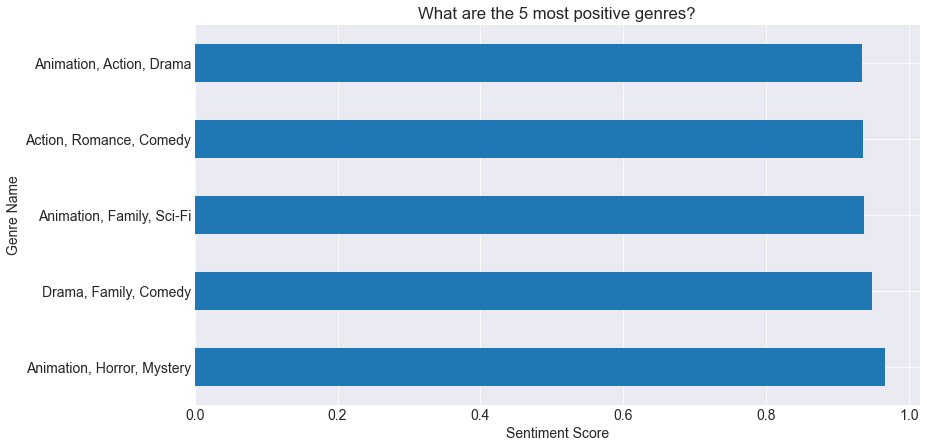

In [48]:
df.groupby("genre").sentiment.mean().sort_values(ascending=False).head(5).plot.barh()
plt.title("What are the 5 most positive genres?")
plt.xlabel("Sentiment Score")
plt.ylabel("Genre Name")

Text(0, 0.5, 'Genre Name')

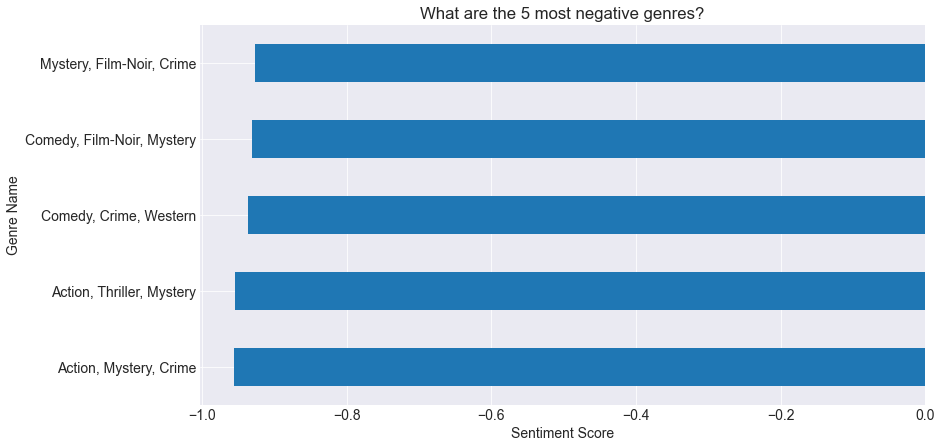

In [49]:
df.groupby("genre").sentiment.mean().sort_values().head(5).plot.barh()
plt.title("What are the 5 most negative genres?")
plt.xlabel("Sentiment Score")
plt.ylabel("Genre Name")

In [50]:
# What is the most positive movie description?

df.nlargest(1, "sentiment").description.values

array(['After winning money gambling in Reno, George enjoys a streak of luck that brings him happiness and success. He dates a beautiful woman and works with a friend in business and then his luck changes while comedy ensues.'],
      dtype=object)

In [51]:
# What is the most negative movie description?

df.nsmallest(1, "sentiment").description.values

array(["In Kentucky just after the Civil War, the Hayden-Colby feud leads to Jed Colby being sent to prison for 15 years for murder. The Haydens head for Nevada and when Colby gets out of prison he heads there also seeking revenge. The head of the Hayden family tries to avoid more killing but the inevitable showdown has to occur, complicated by Lynn Hayden and Ellen Colby's plans to marry."],
      dtype=object)

It seems that overall, animation movies tend to have more positive descriptions. This makes sense, as most animation movies tend to target a younger audience, or a family audience. It should be noted that we are using a sentiment analysis that was largely developed for social media analysis, and as such, it was trained on a a very different corpus. 

## Further questions

1. Does the publish month make a difference in gross_income?
1. Does the publish month make a difference in avg_vote?

# Modeling

For modeling, we will most likely need to do a bag of words, and then use those features are a metric for clustering

The simple recommendation model:

* We will look to do a traditional clustering, by looking at features that are already numerical. These features will be:
    * Year release
    * Run time
    * Avg vote
    * Do a `One Hot Encoder` for genre
  
A more advance model would look to use NLP practices to actually model based on the description, on top of some of the other features previously mentioned.
 

### Simple Model

Steps:

1. Filter data based on the genre
2. Cluster the data based on `avg_votes`, `usa_gross_income`, `year` and `duration`

In [52]:
df_num = df[["title", "avg_vote", "usa_gross_income", "year", "duration"]]

In [53]:
df_num = df_num.set_index("title")

In [54]:
df_num

,avg_vote,usa_gross_income,year,duration
title,,,,
Cleopatra,5.2,5548375.0,1912,100
"From the Manger to the Cross; or, Jesus of Nazareth",5.7,5548375.0,1912,60
"Home, Sweet Home",5.7,5548375.0,1914,55
The Avenging Conscience: or 'Thou Shalt Not Kill',6.5,5548375.0,1914,78
The Bargain,6.6,5548375.0,1914,70
...,...,...,...,...
Adventures of Aladdin,1.7,5548375.0,2019,87
The Hard Way,4.8,5548375.0,2019,92
The Banana Splits Movie,5.0,5548375.0,2019,89


Text(0.5, 0, 'Movie Duration, in minutes')

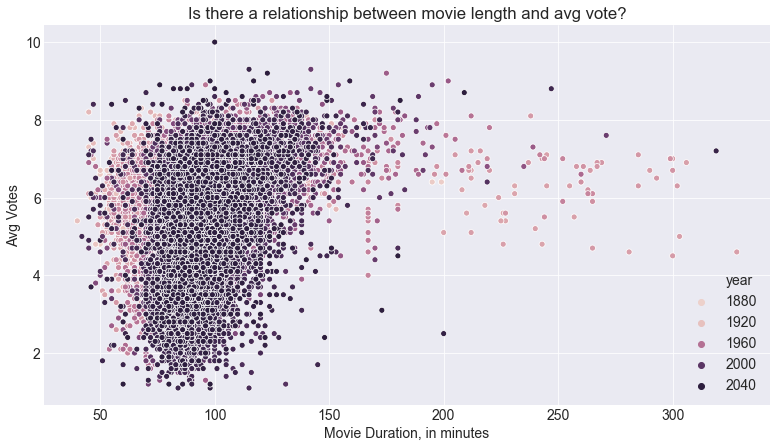

In [55]:
sns.scatterplot(data = df_num, x= "duration", y= "avg_vote", hue="year")
plt.title("Is there a relationship between movie length and avg vote?")
plt.ylabel("Avg Votes")
plt.xlabel("Movie Duration, in minutes")


Interestingly, we see that there is not a very distinct difference between movie length and avg score. It is insteresting, however, that newer movies (post-2000) seem to be, on average, a bit longer. 

Text(0.5, 0, 'USA Gross Income, in dollars')

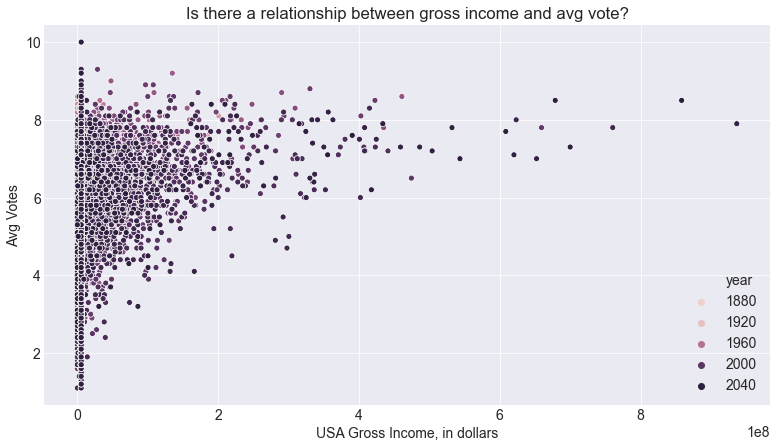

In [56]:
sns.scatterplot(data = df_num, x= "usa_gross_income", y= "avg_vote", hue="year")
plt.title("Is there a relationship between gross income and avg vote?")
plt.ylabel("Avg Votes")
plt.xlabel("USA Gross Income, in dollars")

It also seems that there are not a lot of significant differences between gross income and movie score. This is probably largely influenced by the fact that we had to impude some of the missing income, resulting in some similar results.

In [57]:
# First, we need to scale the data

minmax = MinMaxScaler()

scaled_df = minmax.fit_transform(df_num)

In [58]:
# Create an instance of KMeans 
kmeans = KMeans(n_clusters=50)
# Use fit_predict to cluster the dataset
predictions = kmeans.fit_predict(scaled_df)

In [59]:
df["cluster"] = predictions

In [60]:
df["cluster"] = "cluster_" + df.cluster.astype(str)

-----

#### Test 1

In [61]:
def simple_movie_recommender(df, test):

    is_in_data = ''
    for i in df['title']:
        if test == i :
            is_in_data = True

    if is_in_data == True:
        index = df[df.title == test].index
        
        genre_type = df[df.title == test].genre.values

        cluster = df[df.title == test].cluster.values

        recommended_movies = df[(df.genre.str.contains(genre_type[0])) & (df.cluster.str.contains(cluster[0]))].sort_values(by="avg_vote", ascending=False)
        
        recommended_movies = recommended_movies[recommended_movies.index != index[0]]

        return recommended_movies[["title", "director", "year", "genre", "avg_vote", "usa_gross_income"]].head(25)

    else:
        return "Movie Not in the Database or Not Spelled Correctly"

In [62]:
# Now we test

test = "Toy Story"

In [63]:
simple_movie_recommender(df, test)

,title,director,year,genre,avg_vote,usa_gross_income
51470,Up,"Pete Docter, Bob Peterson",2009,"Animation, Adventure, Comedy",8.2,293004164.0
25601,Aladdin,"Ron Clements, John Musker",1992,"Animation, Adventure, Comedy",8.0,217350219.0
34846,"Monsters, Inc.","Pete Docter, David Silverman",2001,"Animation, Adventure, Comedy",8.0,289916256.0
43202,Ratatouille,"Brad Bird, Jan Pinkava",2007,"Animation, Adventure, Comedy",8.0,206445654.0
30272,Toy Story 2,"John Lasseter, Ash Brannon",1999,"Animation, Adventure, Comedy",7.9,245852179.0
30955,Shrek,"Andrew Adamson, Vicky Jenson",2001,"Animation, Adventure, Comedy",7.8,267665011.0
59548,Wreck-It Ralph,Rich Moore,2012,"Animation, Adventure, Comedy",7.7,189422889.0
43793,Tangled,"Nathan Greno, Byron Howard",2010,"Animation, Adventure, Comedy",7.7,200821936.0
69060,Moana,"Ron Clements, John Musker",2016,"Animation, Adventure, Comedy",7.6,248757044.0
38103,Ice Age,"Chris Wedge, Carlos Saldanha",2002,"Animation, Adventure, Comedy",7.5,176387405.0


------

#### Test 2

In [64]:
def simple_movie_recommender(df, test):

    is_in_data = ''
    for i in df['title']:
        if test == i :
            is_in_data = True

    if is_in_data == True:
        index = df[df.title == test].index
        
        genre_type = df[df.title == test].genre.values

        cluster = df[df.title == test].cluster.values

        recommended_movies = df[(df.genre.str.contains(genre_type[0])) & (df.cluster.str.contains(cluster[0]))].sort_values(by="avg_vote", ascending=False)
        
        recommended_movies = recommended_movies[recommended_movies.index != index[0]]

        return recommended_movies[["title", "director", "year", "genre", "avg_vote", "usa_gross_income"]].head(25)

    else:
        return "Movie Not in the Database or Not Spelled Correctly"

In [65]:
test = "Bridesmaids"

In [66]:
simple_movie_recommender(df, test)

,title,director,year,genre,avg_vote,usa_gross_income
31176,There's Something About Mary,"Bobby Farrelly, Peter Farrelly",1998,"Comedy, Romance",7.1,176484651.0
44075,The 40 Year Old Virgin,Judd Apatow,2005,"Comedy, Romance",7.1,109449237.0
35564,Meet the Parents,Jay Roach,2000,"Comedy, Romance",7.0,166244045.0
43708,Wedding Crashers,David Dobkin,2005,"Comedy, Romance",6.9,209255921.0
47223,Knocked Up,Judd Apatow,2007,"Comedy, Romance",6.9,148768917.0


We see that our function works relatively well. The way the function works is that it looks in the database for the genre and cluster that the `test` title has. It then filters that data using these masks, and returns the top 25 matches of titles that have a similar genre, and at the same time had a similar run-time, release year, avg votes and year (based on the cluster). 

The tool works fairly well, but ceirtainly requires further testing. Some of the abilities I want to implement:

1. If a movie title is duplicated (i.e "Parent Trap"), then it would assume that it is the most recent title. 
1. At the moment, the tool only looks at the first genre. For example, if a movie is categorized as "Action, Adventure, Comedy", the matches are based on containing only "Action". By implementing a series of conditionals, it might be possible to further improve the model's accuracy.

In order to improve the accuracy of the model, I am hoping we can use more advanced NLP techniques to actually group recommendations based on the movie descriptions.

### Complex Model

Steps:

1. Filter data based on genre
1. Cluster the data based on the TFIDF of the description.

In [67]:
df = prepare_data()

In [68]:
df = prep_readme_data(df, "description")

In [69]:
df = model.simple_cluster(df, 5)

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26102 entries, 2 to 81265
Data columns (total 23 columns):
imdb_title_id         26102 non-null object
title                 26102 non-null object
original_title        26102 non-null object
year                  26102 non-null int64
date_published        26102 non-null object
genre                 26102 non-null object
duration              26102 non-null int64
country               26102 non-null object
language              26102 non-null object
director              26102 non-null object
writer                26102 non-null object
production_company    26102 non-null object
actors                26102 non-null object
description           26102 non-null object
avg_vote              26102 non-null float64
votes                 26102 non-null int64
budget                26102 non-null float64
usa_gross_income      26102 non-null float64
basic_clean           26102 non-null object
clean_tokes           26102 non-null object
lemmatized 

In [71]:
df["combined_data"] = df.genre + " " + df.director + " " + df.clean_lemmatized

In [72]:
tfidf = TfidfVectorizer()

In [73]:
tfidfs = tfidf.fit_transform(df.clean_lemmatized)
tfidfs

<26102x29585 sparse matrix of type '<class 'numpy.float64'>'
	with 389280 stored elements in Compressed Sparse Row format>

In [74]:
# Create an instance of KMeans to find seven clusters
kmeans = KMeans(n_clusters=15)
# Use fit_predict to cluster the dataset
predictions = kmeans.fit_predict(tfidfs)


In [75]:
df["cluster_description"] = predictions

In [76]:
df["cluster_description"] = "cluster_" + df.cluster_description.astype(str)

------

#### Test 1

In [77]:
def complex_movie_recommendation(df, test):
    is_in_data = ''
    for i in df['title']:
        if test == i :
            is_in_data = True

    if is_in_data == True:
        index = df[df.title == test].index

        genre_type = df[df.title == test].genre.values

        cluster = df[df.title == test].cluster.values

        cluster_desc = df[df.title == test].cluster_description.values

        recommended_movies = (
            df[(df.genre.str.contains(genre_type[0])) 
               & (df.cluster.str.contains(cluster[0]))
               & (df.cluster_description.str.contains(cluster_desc[0]))]
            .sort_values(by="avg_vote", ascending=False)
        )

        recommended_movies = recommended_movies[recommended_movies.index != index[0]]
        
        if len(recommended_movies) == 0:
            recommended_movies = df[(df.genre.str.contains(genre_type[0])) & (df.cluster.str.contains(cluster[0]))].sort_values(by="avg_vote", ascending=False)
        
            recommended_movies = recommended_movies[recommended_movies.index != index[0]]
            
        if len(recommended_movies) == 0:
            return "No Recommendations Found"

        recommended_movies[["title", "director", "year", "genre", "avg_vote", "usa_gross_income"]].head(25)
        return recommended_movies[["title", "director", "year", "genre", "avg_vote", "usa_gross_income"]].head(25)

    else:
        return "Movie Not in the Database or Not Spelled Correctly"

In [78]:
test = "Toy Story"

In [79]:
complex_movie_recommendation(df, test)

,title,director,year,genre,avg_vote,usa_gross_income
45362,Toy Story 3,Lee Unkrich,2010,"Animation, Adventure, Comedy",8.3,415004880.0
51470,Up,"Pete Docter, Bob Peterson",2009,"Animation, Adventure, Comedy",8.2,293004164.0
66770,Zootopia,"Byron Howard, Rich Moore",2016,"Animation, Adventure, Comedy",8.0,341268248.0
43202,Ratatouille,"Brad Bird, Jan Pinkava",2007,"Animation, Adventure, Comedy",8.0,206445654.0
34846,"Monsters, Inc.","Pete Docter, David Silverman",2001,"Animation, Adventure, Comedy",8.0,289916256.0
30272,Toy Story 2,"John Lasseter, Ash Brannon",1999,"Animation, Adventure, Comedy",7.9,245852179.0
30955,Shrek,"Andrew Adamson, Vicky Jenson",2001,"Animation, Adventure, Comedy",7.8,267665011.0
69060,Moana,"Ron Clements, John Musker",2016,"Animation, Adventure, Comedy",7.6,248757044.0
63704,Frozen,"Chris Buck, Jennifer Lee",2013,"Animation, Adventure, Comedy",7.5,400738009.0
81051,Shrek Retold,Grant Duffrin,2018,"Animation, Adventure, Comedy",7.4,5548375.0


-------

**Test 2**

In [80]:
test = "Bridesmaids"

In [81]:
complex_movie_recommendation(df, test)

,title,director,year,genre,avg_vote,usa_gross_income
45411,East Side Story,Carlos Portugal,2006,"Comedy, Romance",6.6,5548375.0
39814,The Movie Hero,Brad T. Gottfred,2003,"Comedy, Romance",6.5,5548375.0
43902,The Baxter,Michael Showalter,2005,"Comedy, Romance",6.5,181872.0
47330,Ira & Abby,Robert Cary,2006,"Comedy, Romance",6.5,221096.0
46981,Coffee Date,Stewart Wade,2006,"Comedy, Romance",6.2,4412.0
36782,Good Advice,Steve Rash,2001,"Comedy, Romance",6.2,5548375.0
35496,In the Weeds,Michael Rauch,2000,"Comedy, Romance",6.0,5548375.0
45077,I Am a Sex Addict,Caveh Zahedi,2005,"Biography, Comedy, Romance",6.0,115694.0
58822,Nesting,John Chuldenko,2012,"Comedy, Romance",5.8,5548375.0
38862,Life or Something Like It,Stephen Herek,2002,"Comedy, Romance",5.8,14448589.0


-------

**Test 3**

In [82]:
test = "A Quiet Place"

In [83]:
complex_movie_recommendation(df, test)

,title,director,year,genre,avg_vote,usa_gross_income
66081,Bird Box,Susanne Bier,2018,"Drama, Horror, Sci-Fi",6.6,5548375.0
56184,Stake Land,Jim Mickle,2010,"Drama, Horror, Sci-Fi",6.5,33245.0
63919,Uncanny,Matthew Leutwyler,2015,"Drama, Horror, Sci-Fi",6.3,5548375.0
48697,Carriers,"David Pastor, Àlex Pastor",2009,"Drama, Horror, Sci-Fi",6.0,104352.0
70613,Chicago Rot,Dorian Weinzimmer,2016,"Drama, Horror, Sci-Fi",5.6,5548375.0


The logic behind the code is working as I expect it - however, there needs to be further testing with the size of the clusters to better arrive at an optimal recommendation